In [41]:
# Install cryptography library
import time
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # Added for prettier graphs
from abc import ABC, abstractmethod

# Cryptographic Primitives
from cryptography.hazmat.primitives.asymmetric import rsa, ec
from cryptography.hazmat.primitives import serialization, hashes
from cryptography.hazmat.primitives.ciphers.aead import ChaCha20Poly1305, AESGCM
from cryptography.hazmat.primitives.kdf.hkdf import HKDF

In [42]:
# --- CONFIGURATION ---

# 1. Defined Scenarios with realistic file sizes
TEST_SCENARIOS = {
    "Tiny (Handshake/Auth)": 64,             # 64 Bytes
    "Small (Chat Message)": 512,             # 512 Bytes
    "Medium (JSON/API)": 4 * 1024,           # 4 KB
    "Large (Image/Doc)": 1024 * 1024,        # 1 MB
    "X-Large (App/Video)": 10 * 1024 * 1024, # 10 MB
    "Huge (Backup/ISO)": 50 * 1024 * 1024    # 50 MB (Change to 100MB if CPU is fast)
}

# 2. Iterations
# We use fewer iterations for large files to save time, more for small files for accuracy.
def get_iterations(size_bytes):
    if size_bytes > 10 * 1024 * 1024: return 5  # Large files: 5 runs
    if size_bytes > 1024 * 1024: return 20      # Medium files: 20 runs
    return 100                                  # Small files: 100 runs

print(f"✅ Configuration Loaded: {len(TEST_SCENARIOS)} scenarios defined.")

✅ Configuration Loaded: 6 scenarios defined.


In [43]:
class AsymmetricSystem(ABC):
    @abstractmethod
    def generate_keys(self): pass
    @abstractmethod
    def get_name(self): pass

# --- RSA: The Old Standard ---
class RSA_Engine(AsymmetricSystem):
    def __init__(self, bits):
        self.bits = bits
    def get_name(self): return f"RSA-{self.bits}"
    
    def generate_keys(self):
        # RSA generation is very heavy [cite: 33]
        k = rsa.generate_private_key(public_exponent=65537, key_size=self.bits)
        return k.public_key()

# --- ECC: NIST Curves (SECP) ---
class ECC_NIST_Engine(AsymmetricSystem):
    def __init__(self, curve, name):
        self.curve = curve
        self.name = name
    def get_name(self): return f"ECC-{self.name}"
    
    def generate_keys(self):
        # ECC scalar multiplication is fast [cite: 47]
        k = ec.generate_private_key(self.curve)
        return k.public_key()

# --- ECC: Modern Curve (X25519) ---
# X25519 is specifically designed for ECDH Key Exchange speed
class ECC_X25519_Engine(AsymmetricSystem):
    def get_name(self): return "ECC-X25519"
    
    def generate_keys(self):
        # Note: X25519 keys are different object types in this library
        k = x25519.X25519PrivateKey.generate()
        return k.public_key()

In [44]:
class SymmetricSystem(ABC):
    @abstractmethod
    def encrypt(self, data: bytes, key: bytes) -> bytes: pass
    @abstractmethod
    def get_name(self): pass

class AES_GCM_Engine(SymmetricSystem):
    def get_name(self): return "AES-256-GCM"
    def encrypt(self, data, key):
        nonce = os.urandom(12)
        return AESGCM(key).encrypt(nonce, data, None)

class ChaCha20_Engine(SymmetricSystem):
    def get_name(self): return "ChaCha20-Poly1305"
    def encrypt(self, data, key):
        nonce = os.urandom(12)
        return ChaCha20Poly1305(key).encrypt(nonce, data, None)

In [45]:
class SecureChannelSession:
    """
    Simulates a full session: Handshake (ECC) -> Key Derivation -> Encryption (AES/ChaCha)
    """
    def __init__(self, cipher_engine):
        self.cipher_engine = cipher_engine
        self.derived_key = None

    def handshake_overhead(self):
        """Measures ONLY the time to establish the shared key (ECDHE)"""
        # 1. Generate Ephemeral Keys (Forward Secrecy) [cite: 54]
        alice = ec.generate_private_key(ec.SECP256R1())
        bob = ec.generate_private_key(ec.SECP256R1())
        
        # 2. Exchange & Compute Shared Secret
        shared_secret = alice.exchange(ec.ECDH(), bob.public_key())
        
        # 3. Derive Session Key (HKDF)
        self.derived_key = HKDF(
            algorithm=hashes.SHA256(), length=32, salt=None, info=b'handshake'
        ).derive(shared_secret)

    def full_transmission(self, payload):
        """Measures Handshake + Encryption of specific payload"""
        self.handshake_overhead()
        return self.cipher_engine.encrypt(payload, self.derived_key)

In [46]:
class BenchmarkSuite:
    def __init__(self):
        self.results = []

    def measure(self, category, algo_name, task, func, size_bytes=0, size_label="-"):
        """Generic timing function with warm-up and average calculation"""
        iters = get_iterations(size_bytes) if size_bytes > 0 else 20
        timings = []

        try:
            func() # Warm-up run
            for _ in range(iters):
                start = time.perf_counter()
                func()
                end = time.perf_counter()
                timings.append(end - start)
            
            avg_time = sum(timings) / len(timings)
            
            # Metrics
            throughput_mbps = 0
            if size_bytes > 0:
                throughput_mbps = (size_bytes / 1024 / 1024) / avg_time

            self.results.append({
                "Category": category,
                "Algorithm": algo_name,
                "Task": task,
                "Label": size_label,
                "Size_Bytes": size_bytes,
                "Time_Seconds": avg_time,
                "Throughput_MBps": throughput_mbps
            })
            print(f"   Done: {algo_name} ({size_label}) -> {avg_time:.5f}s")
            
        except Exception as e:
            print(f"   ERROR {algo_name}: {e}")

    def run_all(self):
        print("🚀 STARTING COMPREHENSIVE BENCHMARK...\n")
        
        # --- 1. ASYMMETRIC TESTS ---
        print("--- Phase 1: Asymmetric Key Generation ---")
        # Comparing key sizes [cite: 37]
        algos = [
            RSA_Engine(2048), RSA_Engine(3072), RSA_Engine(4096),
            ECC_NIST_Engine(ec.SECP256R1(), "SECP256"),
            ECC_NIST_Engine(ec.SECP384R1(), "SECP384"),
            ECC_NIST_Engine(ec.SECP521R1(), "SECP521")
        ]
        for algo in algos:
            self.measure("Asymmetric", algo.get_name(), "KeyGen", algo.generate_keys)

        # --- 2. SYMMETRIC TESTS ---
        print("\n--- Phase 2: Symmetric Throughput ---")
        aes = AES_GCM_Engine()
        chacha = ChaCha20_Engine()
        key = os.urandom(32)

        for label, size in TEST_SCENARIOS.items():
            print(f"Testing Payload: {label}...")
            data = os.urandom(size) # Simulating data
            
            self.measure("Symmetric", aes.get_name(), "Encrypt", 
                         lambda: aes.encrypt(data, key), size, label)
            
            self.measure("Symmetric", chacha.get_name(), "Encrypt", 
                         lambda: chacha.encrypt(data, key), size, label)

        # --- 3. HYBRID TESTS ---
        print("\n--- Phase 3: Hybrid Protocol Latency ---")
        # Comparing overhead on a small chat message
        payload = os.urandom(512) 
        
        session_aes = SecureChannelSession(aes)
        session_chacha = SecureChannelSession(chacha)
        
        self.measure("Hybrid", "TLS-Sim-AES", "Full-Flow", 
                     lambda: session_aes.full_transmission(payload))
        
        self.measure("Hybrid", "TLS-Sim-ChaCha", "Full-Flow", 
                     lambda: session_chacha.full_transmission(payload))

    def get_results(self):
        return pd.DataFrame(self.results)

# Run it!
suite = BenchmarkSuite()
suite.run_all()
df = suite.get_results()

🚀 STARTING COMPREHENSIVE BENCHMARK...

--- Phase 1: Asymmetric Key Generation ---
   Done: RSA-2048 (-) -> 0.04620s
   Done: RSA-3072 (-) -> 0.18450s
   Done: RSA-4096 (-) -> 0.40761s
   Done: ECC-SECP256 (-) -> 0.00003s
   Done: ECC-SECP384 (-) -> 0.00121s
   Done: ECC-SECP521 (-) -> 0.00256s

--- Phase 2: Symmetric Throughput ---
Testing Payload: Tiny (Handshake/Auth)...
   Done: AES-256-GCM (Tiny (Handshake/Auth)) -> 0.00000s
   Done: ChaCha20-Poly1305 (Tiny (Handshake/Auth)) -> 0.00000s
Testing Payload: Small (Chat Message)...
   Done: AES-256-GCM (Small (Chat Message)) -> 0.00000s
   Done: ChaCha20-Poly1305 (Small (Chat Message)) -> 0.00000s
Testing Payload: Medium (JSON/API)...
   Done: AES-256-GCM (Medium (JSON/API)) -> 0.00001s
   Done: ChaCha20-Poly1305 (Medium (JSON/API)) -> 0.00001s
Testing Payload: Large (Image/Doc)...
   Done: AES-256-GCM (Large (Image/Doc)) -> 0.00065s
   Done: ChaCha20-Poly1305 (Large (Image/Doc)) -> 0.00098s
Testing Payload: X-Large (App/Video)...
   Do

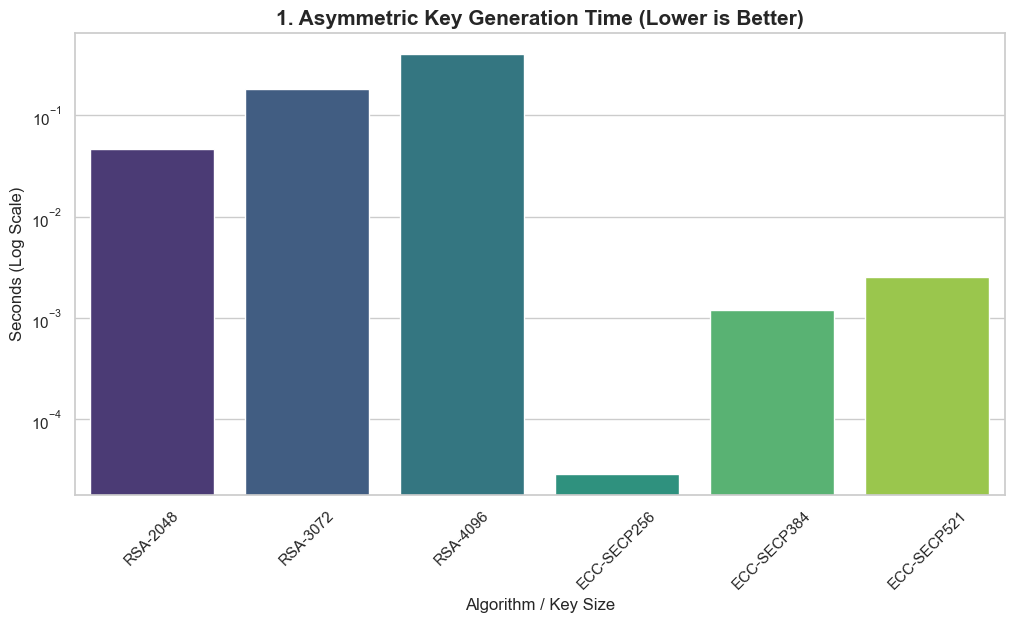

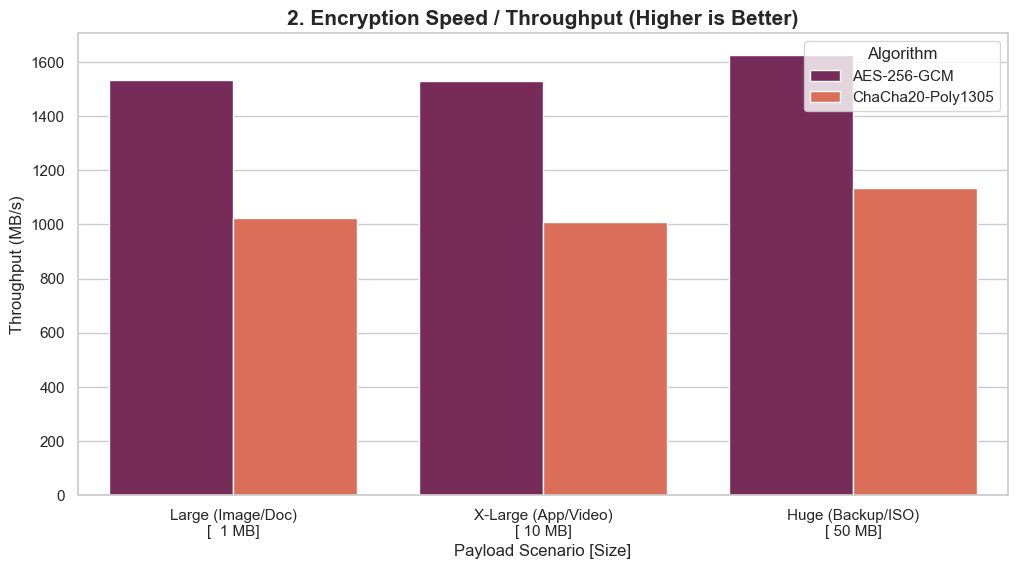

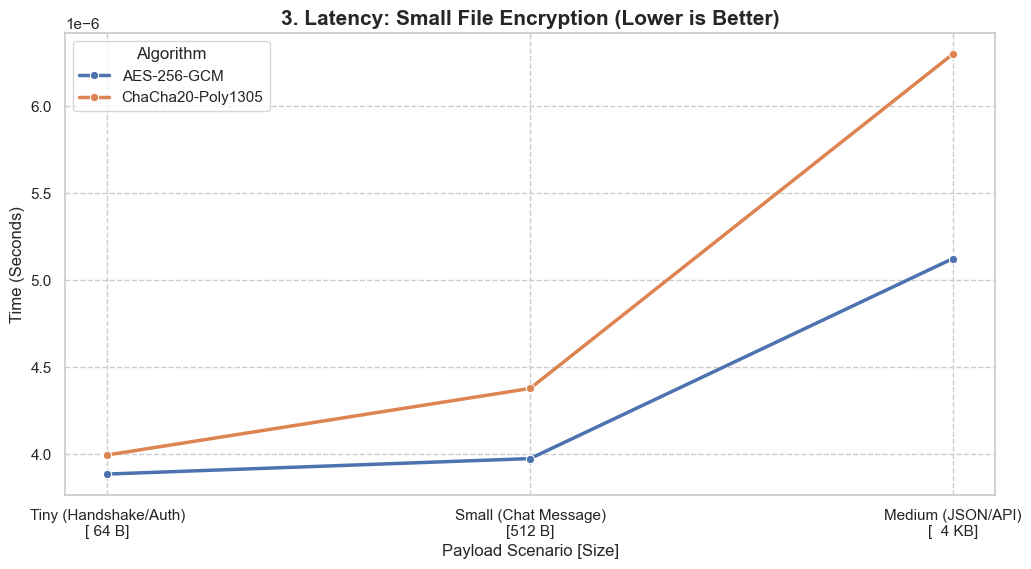

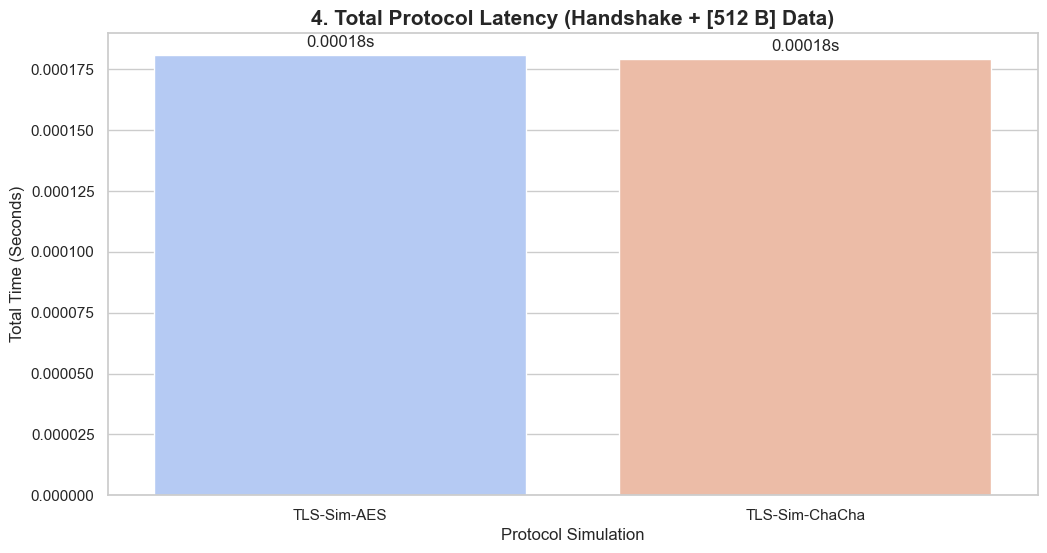


--- 📊 Summary Data Table (Mean Values) ---


Time_Seconds  \
Category   Algorithm         Plot_Label                                     
Asymmetric ECC-SECP256       -                                   0.000029   
           ECC-SECP384       -                                   0.001211   
           ECC-SECP521       -                                   0.002560   
           RSA-2048          -                                   0.046202   
           RSA-3072          -                                   0.184501   
           RSA-4096          -                                   0.407611   
Hybrid     TLS-Sim-AES       -                                   0.000181   
           TLS-Sim-ChaCha    -                                   0.000179   
Symmetric  AES-256-GCM       Huge (Backup/ISO)\n[ 50 MB]         0.030749   
                             Large (Image/Doc)\n[  1 MB]         0.000652   
                             Medium (JSON/API)\n[  4 KB]         0.000005   
                             Small (Chat Message)\n[512 B]       0.000004   
                             Tiny (Handshake/Auth)\n[ 64 B]      0.000004   
                             X-Large (App/Video)\n[ 10 MB]       0.006538   
           ChaCha20-Poly1305 Huge (Backup/ISO)\n[ 50 MB]         0.044076   
                             Large (Image/Doc)\n[  1 MB]         0.000975   
                             Medium (JSON/API)\n[  4 KB]         0.000006   
                             Small (Chat Message)\n[512 B]       0.000004   
                             Tiny (Handshake/Auth)\n[ 64 B]      0.000004   
                             X-Large (App/Video)\n[ 10 MB]       0.009919   

                                                             Throughput_MBps  
Category   Algorithm         Plot_Label                                       
Asymmetric ECC-SECP256       -                                      0.000000  
           ECC-SECP384       -                                      0.000000  
           ECC-SECP521       -                                      0.000000  
           RSA-2048          -                                      0.000000  
           RSA-3072          -                                      0.000000  
           RSA-4096          -                                      0.000000  
Hybrid     TLS-Sim-AES       -                                      0.000000  
           TLS-Sim-ChaCha    -                                      0.000000  
Symmetric  AES-256-GCM       Huge (Backup/ISO)\n[ 50 MB]         1626.078659  
                             Large (Image/Doc)\n[  1 MB]         1534.224714  
                             Medium (JSON/API)\n[  4 KB]          762.343956  
                             Small (Chat Message)\n[512 B]        122.930793  
                             Tiny (Handshake/Auth)\n[ 64 B]        15.718555  
                             X-Large (App/Video)\n[ 10 MB]       1529.408618  
           ChaCha20-Poly1305 Huge (Backup/ISO)\n[ 50 MB]         1134.411932  
                             Large (Image/Doc)\n[  1 MB]         1025.286648  
                             Medium (JSON/API)\n[  4 KB]          619.842767  
                             Small (Chat Message)\n[512 B]        111.581620  
                             Tiny (Handshake/Auth)\n[ 64 B]        15.285543  
                             X-Large (App/Video)\n[ 10 MB]       1008.148359

In [47]:
# Setup professional plotting style
sns.set_theme(style="whitegrid")

# --- HELPER: Format Bytes to Readable String ---
def format_size(size_bytes):
    if size_bytes == 0: return ""
    for unit in ['B', 'KB', 'MB', 'GB']:
        if size_bytes < 1024.0:
            return f"{size_bytes:3.0f} {unit}"
        size_bytes /= 1024.0
    return f"{size_bytes:.1f} GB"

# Create a new column for the X-axis that includes the Dimension
# Example: "Small (Chat Message)" -> "Small (Chat Message)\n[512 B]"
df['Plot_Label'] = df.apply(
    lambda row: f"{row['Label']}\n[{format_size(row['Size_Bytes'])}]" if row['Size_Bytes'] > 0 else row['Label'], 
    axis=1
)

# --- PLOT 1: Asymmetric Key Generation (Log Scale) ---
plt.figure(figsize=(12, 6))
asym_df = df[df['Category'] == "Asymmetric"]

# FIX: Added hue="Algorithm" and legend=False
chart1 = sns.barplot(
    data=asym_df, 
    x="Algorithm", 
    y="Time_Seconds", 
    hue="Algorithm", 
    legend=False, 
    palette="viridis"
)
chart1.set_yscale("log") 
plt.title("1. Asymmetric Key Generation Time (Lower is Better)", fontweight='bold', fontsize=15)
plt.ylabel("Seconds (Log Scale)", fontsize=12)
plt.xlabel("Algorithm / Key Size", fontsize=12)
plt.xticks(rotation=45)
plt.show()

# --- PLOT 2: Symmetric Throughput (MB/s) for Large Files ---
plt.figure(figsize=(12, 6))
# Filter for files >= 1MB
sym_df = df[(df['Category'] == "Symmetric") & (df['Size_Bytes'] >= 1024*1024)]

chart2 = sns.barplot(
    data=sym_df, 
    x="Plot_Label", 
    y="Throughput_MBps", 
    hue="Algorithm", 
    palette="rocket"
)
plt.title("2. Encryption Speed / Throughput (Higher is Better)", fontweight='bold', fontsize=15)
plt.ylabel("Throughput (MB/s)", fontsize=12)
plt.xlabel("Payload Scenario [Size]", fontsize=12)
plt.legend(title="Algorithm", loc='upper right')
plt.show()

# --- PLOT 3: Latency for Small Files (Line Chart) ---
plt.figure(figsize=(12, 6))
# Filter for small files < 1MB
small_files_df = df[(df['Category'] == "Symmetric") & (df['Size_Bytes'] < 1024*1024)]

chart3 = sns.lineplot(
    data=small_files_df, 
    x="Plot_Label", 
    y="Time_Seconds", 
    hue="Algorithm", 
    marker="o", 
    linewidth=2.5
)
plt.title("3. Latency: Small File Encryption (Lower is Better)", fontweight='bold', fontsize=15)
plt.ylabel("Time (Seconds)", fontsize=12)
plt.xlabel("Payload Scenario [Size]", fontsize=12)
plt.grid(True, which="both", ls="--")
plt.show()

# --- PLOT 4: Hybrid Protocol Overhead ---
plt.figure(figsize=(12, 6))
hyb_df = df[df['Category'] == "Hybrid"]

# FIX: Added hue="Algorithm" and legend=False
chart4 = sns.barplot(
    data=hyb_df, 
    x="Algorithm", 
    y="Time_Seconds", 
    hue="Algorithm", 
    legend=False, 
    palette="coolwarm"
)
plt.title("4. Total Protocol Latency (Handshake + [512 B] Data)", fontweight='bold', fontsize=15)
plt.ylabel("Total Time (Seconds)", fontsize=12)
plt.xlabel("Protocol Simulation", fontsize=12)

# Annotation loop logic remains the same
for p in chart4.patches:
    if p.get_height() > 0: # Check to avoid errors with empty bars
        chart4.annotate(f'{p.get_height():.5f}s', 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 9), 
                       textcoords = 'offset points')

plt.show()

# --- DATA SUMMARY TABLE ---
print("\n--- 📊 Summary Data Table (Mean Values) ---")
display(df.groupby(['Category', 'Algorithm', 'Plot_Label'])[['Time_Seconds', 'Throughput_MBps']].mean())